In [1]:
# Librerias generales
import pandas as pd
import numpy as np

# Visualización
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

# Algoritmos
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import Isomap
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

# Tema JupyterNotebook
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### Importar dataset

In [2]:
# Leer los datos
data = pd.read_csv('data.csv')

# Se eliminan los valores nulos
data = data.dropna()

# Mostar las primeros 5 filas
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


Como se puede observar las desviaciones estandar no se encuentran en un mismo rango. Por lo que se hace necesario re escalar los datos. Se utilizará Normalizer.

### Rescalamiento de los datos 

In [4]:
def reescalamiento(df):
    """
    reescalamiento: Esta función reescala el dataset usando XXX.

    Parameters
    ----------
    df: DataFrame para normalizar.

    Returns
    -------
    DataFrame normalizado.
    """
    from sklearn.preprocessing import Normalizer
    """Esta función reescala todo el dataset"""

    # Eliminar columna 'CUST_ID'
    df.drop(['CUST_ID'], axis=1, inplace=True)

    # Reescalar el dataframe
    scaler = Normalizer().fit_transform(df.values)

    df_normalizada = normalize(scaler)
    df_normalizada = pd.DataFrame(df_normalizada)

    # Renombrar las columnas
    df_normalizada.columns = data.columns

    return df_normalizada

In [5]:
df_normalizada = reescalamiento(data)
df_normalizada.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.039353,0.000787,0.091790,0.000000,0.091790,0.00000,0.000160,0.000000,0.000080,0.000000,0.000000,0.001924,0.962156,0.194165,0.134230,0.00000,0.011546
1,0.293876,0.000083,0.000000,0.000000,0.000000,0.59124,0.000000,0.000000,0.000000,0.000023,0.000367,0.000000,0.642358,0.376516,0.098404,0.00002,0.001101
2,0.310798,0.000125,0.096307,0.096307,0.000000,0.00000,0.000125,0.000125,0.000000,0.000000,0.000000,0.001495,0.934206,0.077485,0.078135,0.00000,0.001495
3,0.504284,0.000617,0.009867,0.009867,0.000000,0.00000,0.000051,0.000051,0.000000,0.000000,0.000000,0.000617,0.740040,0.418329,0.150963,0.00000,0.007400
4,0.428658,0.000237,0.315788,0.000000,0.315788,0.00000,0.000158,0.000000,0.000138,0.000000,0.000000,0.001895,0.426330,0.331604,0.570156,0.00000,0.002842


##### Estadística de Hopkins
Prueba la aleatoriedad espacial de los datos e indica la tendencia de agrupación o lo bien que los datos pueden ser agrupados
* 0,5 o menos -->  los datos están distribuidos uniformemente
* 0.77 - 0.99 --> alta tendencia a los cluster 

In [6]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan


def hopkins(X):
    """
    hopkins: El estadístico de Hopkins es un camino para medir la tendencía de clusterización de un dataset.

    Parameters
    ----------
    X: DataFrame normalizado para ser evaluado por la estadística de Hopkins.

    Returns
    -------
    Puntaje que corresponde al valor estadístico de Hopkins.
    """
    d = X.shape[1]
    # d = len(vars) # columns
    n = len(X)  # rows
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X, axis=0), np.amax(
            X, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(
            X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [7]:
# Comprobar estadisticamente si la data si se puede clusterizar
hopkins(df_normalizada)

0.9083429525603778

Se puede concluir que los datos tienen una alta disposición estadísticamente para clusterizar

#### K means
K optimizado : Para escoger al mejor número *K* se utiliza la metodologías del mejor **valor de la silueta**, este valor mide cuán similar es un punto a su propio cluster (cohesión) en comparación con otros cluster (separación). Además se tiene el cuenta la métrica de **Davies Bouldin** que es una medida de similitud promedio de cada cluster con su cluster más similar, donde la similitud es la relación entre las distancias dentro del cluster y las distancias entre los clusters. La puntuación mínima es cero, y los valores más bajos indican una mejor agrupación.

In [8]:
def number_k(df_normalizada):
    """
    number_k: Esta función encuentra el valor de k optimizado a través del valor de silueta. 
    
    Parameters
    ----------
    df_normalizada: DataFrame normalizado para ser evaluado por la estadística de Hopkins.
    
    Returns
    -------
    Gráfico del número óptimo de clusters.
    """
    
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init="k-means++", n_init=100, max_iter=300, random_state=4444) 
        kmeans.fit(df_normalizada)
    
    kmeans_per_k = [KMeans(n_clusters=k, init="k-means++", n_init=100, max_iter=300, random_state=4444).fit(df_normalizada)
                for k in range(1, 10)]
    
    silhouette_score(df_normalizada, kmeans.labels_)

    silhouette_scores = [silhouette_score(df_normalizada, model.labels_)
                         for model in kmeans_per_k[1:]]

    # Gráficar el score de silhoutee
    rcParams['figure.figsize'] = 16, 5
    _ = plt.plot(range(2, 10), silhouette_scores, "bo-", color='blue',
                 linewidth=3, markersize=8, label='Silhoutee curve')
    _ = plt.xlabel("$k$", fontsize=14, family='Arial')
    _ = plt.ylabel("Silhouette score", fontsize=14, family='Arial')
    _ = plt.grid(which='major', color='#cccccc', linestyle='--')

    _ = plt.title('Silhoutte curve for predict optimal number of clusters', family='Arial', fontsize=14)

    # Calcular el número óptimo de clusters
    k = np.argmax(silhouette_scores) + 2

    # Dibujar una línea vertical para marcar el número óptimo de clusters
    _ = plt.axvline(x=k, linestyle='--', c='green', linewidth=3,
                    label='Optimal number of clusters ({})'.format(k))

    _ = plt.scatter(k, silhouette_scores[k-2], c='red', s=400)

    _ = plt.legend(shadow=True)

    _ = plt.show()
    
    for i in range(2, 17):
        kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(df_normalizada)
        print(f'Davies Bouldin Score {i}: {metrics.davies_bouldin_score(df_normalizada,kmeans_labels).round(3)}')
    return _


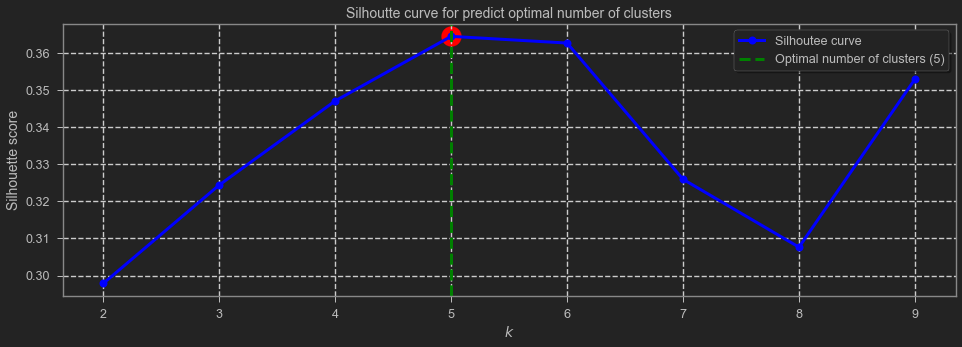

Davies Bouldin Score 2: 1.517
Davies Bouldin Score 3: 1.303
Davies Bouldin Score 4: 1.215
Davies Bouldin Score 5: 1.07
Davies Bouldin Score 6: 1.043
Davies Bouldin Score 7: 1.152
Davies Bouldin Score 8: 1.176
Davies Bouldin Score 9: 1.125
Davies Bouldin Score 10: 1.11
Davies Bouldin Score 11: 1.125
Davies Bouldin Score 12: 1.092
Davies Bouldin Score 13: 1.133
Davies Bouldin Score 14: 1.136
Davies Bouldin Score 15: 1.156
Davies Bouldin Score 16: 1.153


In [9]:
plot_k = number_k(df_normalizada)

Tomando como referencia los valores silueta se concluye que el número de clusters óptimo es de **5**.

In [10]:
def train_model(df_normalizada):
    """
    train_model: Esta función entrena el modelo utilizando isomap para reducir la data y kmeans para clusterizar.
    
    Parameters
    ----------
    df_normalizada: DataFrame normalizado.
    
    Returns
    -------
    Array que corresponde a los clusters de cada cliente del dataset.
    """
    
    # Reducir la data con isomap 2 componentes y 10 neighbors
    isomap = Isomap(n_components=2, n_neighbors = 10)
    df_reducida = isomap.fit_transform(df_normalizada)

    # Instanciar k means
    kmeans = KMeans(n_clusters=5, init="k-means++", n_init=10, max_iter=300, random_state=4444) 

    # Convertir el array en dataframe
    df_reducida = pd.DataFrame(df_reducida)
    kmeans.fit_predict(df_reducida.to_numpy())

    df_reducida["cluster"] = kmeans.labels_

    print(df_reducida["cluster"].value_counts())
    sns.pairplot(df_reducida,hue='cluster',palette='Dark2',diag_kind='kde')
    
    return kmeans.labels_

3    2476
4    2447
0    1501
1    1381
2     831
Name: cluster, dtype: int64


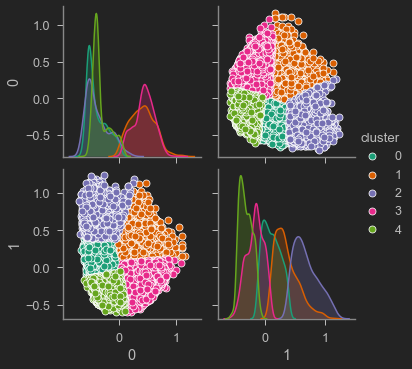

In [11]:
# Normalizer con 5 clusters
clusters = train_model(df_normalizada)

In [12]:
def features_impotances(df_normalizada, clusters):
    """
    features_impotances: Esta función encuentra las variables más importantes aplicando el clasificador de Random Forest.
                         Posteriormente determina la precisión del clasificador para encontrar las features más importantes.
                         
    Parameters
    ----------
    df_normalizada: DataFrame normalizado.
    clusters: Array con los clusters de cada cliente. 
    
    Returns
    -------
    None.
    """
    
    df_normalizada['cluster'] = clusters
    
    # y hace referencia a la columna de los clusters
    X, y = df_normalizada.iloc[:,:-1], df_normalizada.iloc[:,-1]
    
    # Separar la data con un 80% de entrenamiento y 20% de prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4444)
    
    # Crear un clasificador de random forest
    clf = RandomForestClassifier(n_estimators=100, random_state=4444, n_jobs=-1)
    
    # Entrenar el clasificador 
    clf.fit(X_train, y_train)
    
    # Crear un objeto selector que utilizará el clasificador de random forest para identificar
    # características que tienen una importancia de más de 0.06
    sfm = SelectFromModel(clf, threshold=0.06)

    # Entrenar el selector
    sfm.fit(X_train, y_train)

    # Imprimir los nombre de las columnas más importantes
    i = 1
    for feature_list_index in sfm.get_support(indices=True):
        print(f'{i}: {df_normalizada.columns[feature_list_index]}')
        i += 1
        
    # Aplicar el clasificador con todas las funciones a los datos de prueba
    y_pred = clf.predict(X_test)

    # Imprimir la precisión del modelo de entrenado para detectar las features mas importantes
    print(f'La precisión es: {accuracy_score(y_test, y_pred).round(3)}')

    return None

In [14]:
features_imp = features_impotances(df_normalizada, clusters)


1: BALANCE
2: PURCHASES
3: CASH_ADVANCE
4: CREDIT_LIMIT
5: PAYMENTS
6: MINIMUM_PAYMENTS
La precisión es: 0.961


In [14]:
column_imp = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
               'PAYMENTS', 'MINIMUM_PAYMENTS']

#### Guardar datos

In [15]:
# Normalizer con 5 clusters
modelo_final = data.copy()
modelo_final = modelo_final[column_imp]
modelo_final["cluster"] = clusters
modelo_final.head(2)

,BALANCE,PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,cluster
0,40.900749,95.4,0.000000,1000.0,201.802084,139.509787,4
1,3202.467416,0.0,6442.945483,7000.0,4103.032597,1072.340217,3


In [16]:
modelo_final.to_csv('cluster.csv')
modelo_final.cluster.value_counts()

3    2476
4    2447
0    1501
1    1381
2     831
Name: cluster, dtype: int64